In [76]:
DATASET_data = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root"
DATASET_mc = "nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v1.root"

In [53]:
import time
import os
from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2
import dask_awkward as dak
import hist
from hist import Hist
import mplhep as mplhep
from scipy.stats import binom

In [86]:
processor = wideband.DataProcessor(usexroot=True, treename='CrvWidebandTest/WidebandTree', runlist=[1738], userunlist=False, remove=False)
filelist_mc = processor.getFilelist(DATASET_mc)
#append "run" at the end of each file name
filelist_mc = ["{}{}".format(i, ":CrvWidebandTest/WidebandTree") for i in filelist_mc]

processor = wideband.DataProcessor(usexroot=True, treename='run', runlist=[1738], userunlist=False, remove=False)
filelist_data = processor.getFilelist(DATASET_data)
#append "run" at the end of each file name
filelist_data = ["{}{}".format(i, ":run") for i in filelist_data]

In [164]:
%%time
#List of variable to export to a skimmed array
varlist=['spillNumber', 'eventNumber','runNumber', 'subrunNumber',
         'trackPEs', 'trackPoints', 'trackChi2', 'trackIntercept', 'trackSlope']

all_layers = np.arange(0,16) 
test_layers = np.arange(2,6) # Test layers are 2 through 6
trig_layers = all_layers[~np.isin(all_layers, test_layers)]
varlist.extend(['nTrigHits', 'PEsTestLayers', "mc"])
#varlist.extend(['PEsTestLayers'])

ar_skim_list = []

filelist = filelist_mc + filelist_data
for idx, filename in enumerate(filelist):
    if idx%20 == 0:
        print("Processing file: %s"%filename)
    file = uproot.open(filename)
    for ar in file.iterate(step_size="10MB", 
                                   filter_name=['PEs', varlist], 
                                   report=False, library='ak'):
        # Set PEs to zero for aging and quad-counters
        ak.to_numpy(ar['PEs'])[:,0,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,3,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,7,0:7] = 0
                
        # Filter out hits below 5PE
        ar_trig_filt = ak.where(ar['PEs'] >= 5, ar['PEs'], 0)
        # Calculate PEs for even and odd layers
        PEs_even_layers = ak.sum(ar_trig_filt[:, :, 0:31], axis=-1).to_numpy()
        PEs_odd_layers = ak.sum(ar_trig_filt[:, :, 32:64], axis=-1).to_numpy()        
        # Interleave the elements from even and odd arrays
        PEs_interleaved = np.concatenate((PEs_even_layers[:, :, np.newaxis], PEs_odd_layers[:, :, np.newaxis]), axis=2)
        # Reshape the interleaved array to match the desired shape
        PEs_stacked = PEs_interleaved.reshape(-1, 16)        
        # Add PEs for even and odd layers to the original array
        ar['PEsAllLayer'] = PEs_stacked
        
        # Count the number of triggered layers
        ar['nTrigHits'] = ak.sum(ar['PEsAllLayer'][:, trig_layers] > 0, axis=-1)
        # Filter out events with more than 10 triggered layers
        ar = ar[ar['nTrigHits'] > 10]
        # Extract only PEsTestLayers to save memory
        ar['PEsTestLayers'] = ar['PEsAllLayer'][:, test_layers]
        
        if "cosmics-mc" in filename:
            ar['mc'] = True
            ar['trackIntercept'] = ar['trackIntercept'] - 20950.0
        else:
            ar['mc'] = False
        
        # Append to the list
        ar_skim_list.append(ar[varlist])

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v1/root/47/71/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v1.001001_00000000.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v1/root/a8/36/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v1.001001_00000011.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v1/root/cb/7d/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v1.001001_00000022.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_0011_v1/root/77/c1/nts.mu2e.CRV_wideband_cosmics-mc.config_0011_v1.001001_00000036.root:CrvWidebandTest/WidebandTree
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/CRV_wideband_cosmics-mc/config_00

In [246]:
ar_skim = ak.concatenate(ar_skim_list, axis=0)
# Number of layer hits in the test module
ar_skim['nTestHits'] = ak.sum(ar_skim['PEsTestLayers'] > 10, axis=-1)
# Chi2NDF only if denominator if > 0
ar_skim['trackChi2NDF'] = ak.where(ar_skim['trackPoints'] > 2, ar_skim['trackChi2'] / (ar_skim['trackPoints'] - 2), -999)

In [197]:
# Cuts
chi2NDF_limit = 30
#intercept_lower_limit = -1E10
#intercept_upper_limit = 1E10
intercept_lower_limit = -700
intercept_upper_limit = -200
trackPoints_limit = 40
trackPEs_limit = 3000
nTrigHits_limit = 12

# Define the cut conditions
condition_chi2 = (ar_skim["trackChi2"] / ar_skim["trackPoints"] - 2) < chi2NDF_limit
condition_intercept = (ar_skim["trackIntercept"] > intercept_lower_limit) & (ar_skim["trackIntercept"] < intercept_upper_limit)
condition_trackPEs = ar_skim["trackPEs"] < trackPEs_limit
condition_nTrigHits = ar_skim["nTrigHits"] >= nTrigHits_limit
condition_trackPoints = ar_skim["trackPoints"] < trackPoints_limit

# Cut categories
cut_categories = [condition_chi2, condition_intercept, condition_trackPEs, condition_nTrigHits, 
                  condition_chi2 & condition_intercept & condition_trackPEs & condition_nTrigHits & condition_trackPoints]

In [205]:
# Create histograms
axis1 = hist.axis.IntCategory(label='NHits', name='nhits', categories=[1, 2, 3, 4])
axis2 = hist.axis.StrCategory(label='Cuts', name='cut', categories=["trackChi2", "intercept", "trackPEs", "nTrigHits", "all"])
#axis3 = hist.axis.StrCategory(label='Data type', name='data_type', categories=["MC", "Data"])
axis3 = hist.axis.Boolean(label='MC type', name="is_mc")
axis4 = hist.axis.IntCategory(label='NLayers', name='layer', categories=[1, 2, 3, 4])

h_nTrigHits = Hist(hist.axis.Regular(6, 8, 14, name="nTrigHits"), axis1, axis2, axis3)
h_PEsTestLayers = Hist(hist.new.Reg(100, 0, 200, name="PEsTestLayers"), axis1, axis2, axis3)
h_trackChi2NDF = Hist(hist.new.Reg(100, 0, 100, name="trackChi2NDF"), axis1, axis2, axis3)
h_trackPEs = Hist(hist.new.Reg(100, 1000, 5000, name="trackPEs"), axis1, axis2, axis3)
h_trackPoints = Hist(hist.new.Reg(80, 0, 80, name="trackPoints"), axis1, axis2, axis3)
h_trackIntercept = Hist(hist.new.Reg(80, -1000, 100, name="trackIntercept"), axis1, axis2, axis3)
h_trackSlope = Hist(hist.new.Reg(80, -1, 1, name="trackSlope"), axis1, axis2, axis3)

h_trackPEsHit = Hist(hist.new.Reg(100, 0, 500, name="trackPEsHit"), axis1, axis2, axis3)

h_PEsLayer = Hist(hist.new.Reg(100, 0, 500, name="PEsLayer", flow=True), axis1, axis2, axis3, axis4)
h_PEsLayerSort = Hist(hist.new.Reg(100, 0, 500, name="PEsLayerSort", flow=True), axis1, axis2, axis3, axis4)

histogram_list = [h_nTrigHits, h_PEsTestLayers, h_trackChi2NDF, 
                  h_trackPEs, h_trackPoints, h_trackIntercept, h_trackSlope]

# Iterate over nhits values and fill the histograms
for isMC in [True, False]:
    mc_condition = (ar_skim["mc"] == isMC)
    for nhits in axis1:
        hits_condition = ar_skim['nTestHits'] <= nhits
        for idx, cut in enumerate(axis2):

            cut_condition = cut_categories[idx] & hits_condition & mc_condition

            for histogram in histogram_list:
                var_name = histogram.axes[0].label
                if(var_name == "PEsTestLayers"):
                    arr_fill = ak.flatten(ar_skim[cut_condition][var_name])
                else:
                    arr_fill = ar_skim[cut_condition][var_name]
                histogram.fill(arr_fill, nhits=nhits, cut=cut, is_mc=isMC)

            h_trackPEsHit.fill(ar_skim[cut_condition]['trackPEs']/ar_skim[cut_condition]['trackPoints'], nhits=nhits, cut=cut, is_mc=isMC)

            for layer in axis4:
                h_PEsLayer.fill(ar_skim[cut_condition]['PEsTestLayers'][:,layer-1], nhits=nhits, cut=cut, is_mc=isMC, layer=layer)
                h_PEsLayerSort.fill(ak.sort(ar_skim[cut_condition]['PEsTestLayers'], axis=1)[:,layer-1], nhits=nhits, cut=cut, is_mc=isMC, layer=layer)
histogram_list.extend([h_trackPEsHit, h_PEsLayerSort, h_PEsLayer])

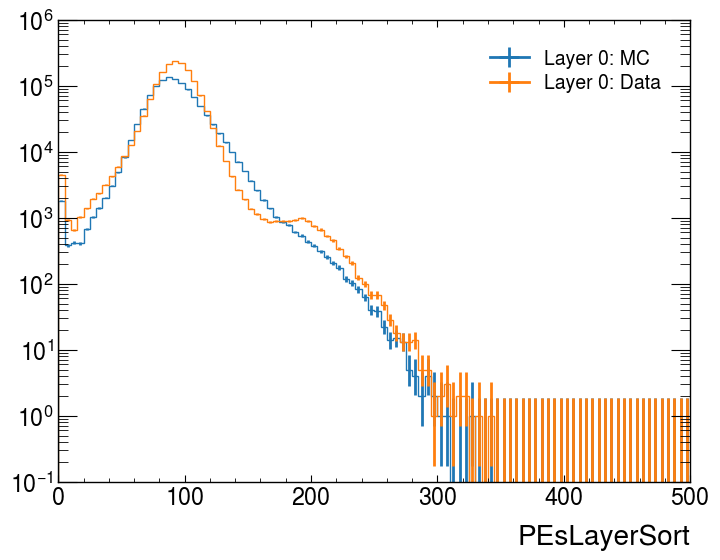

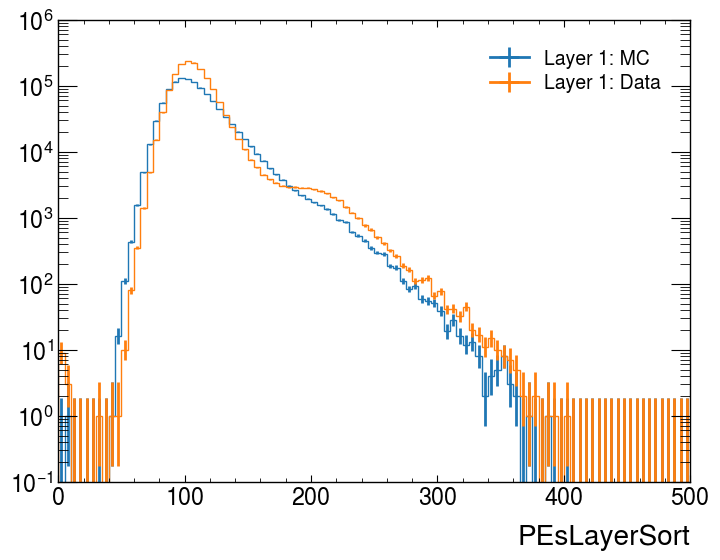

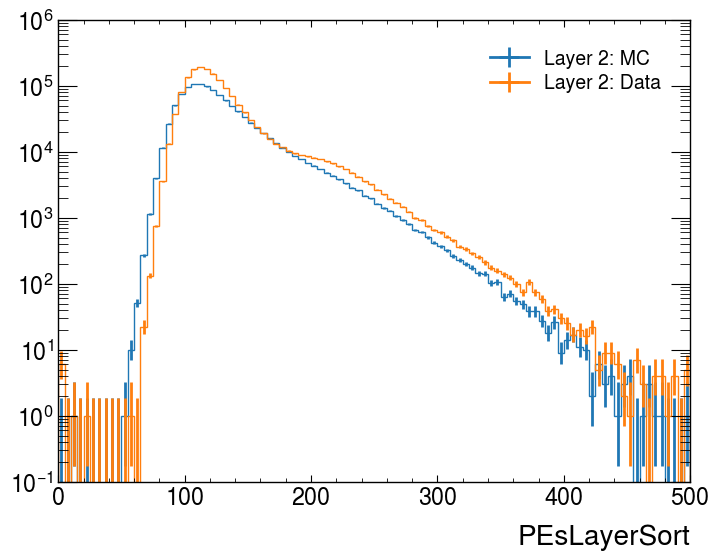

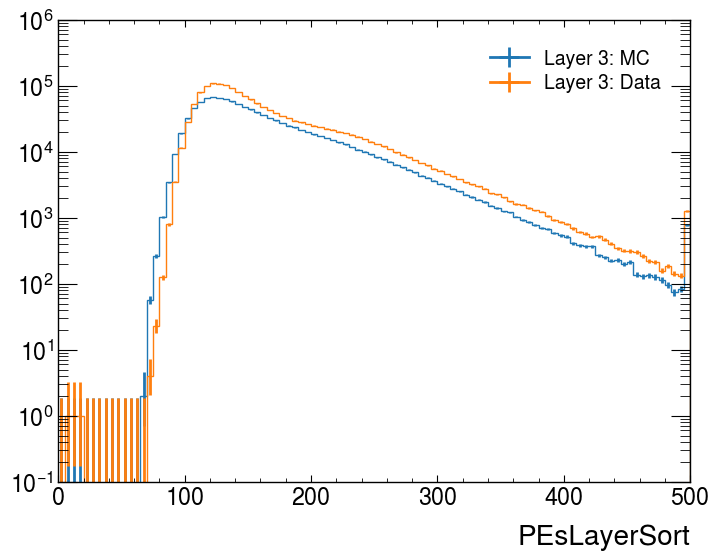

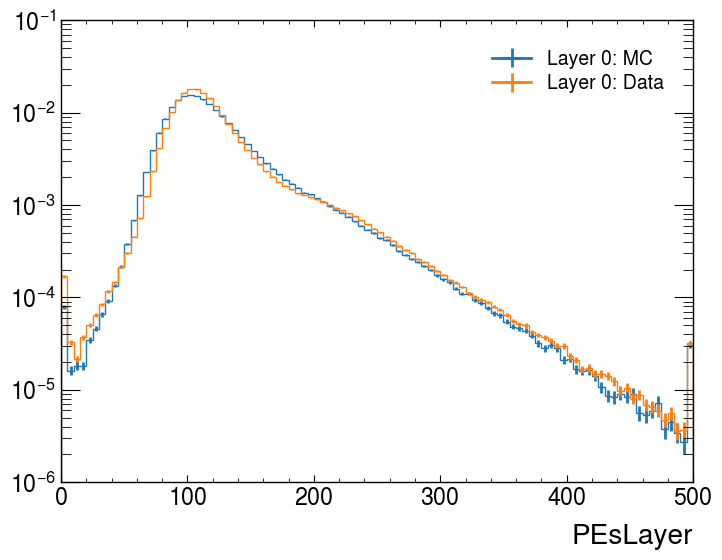

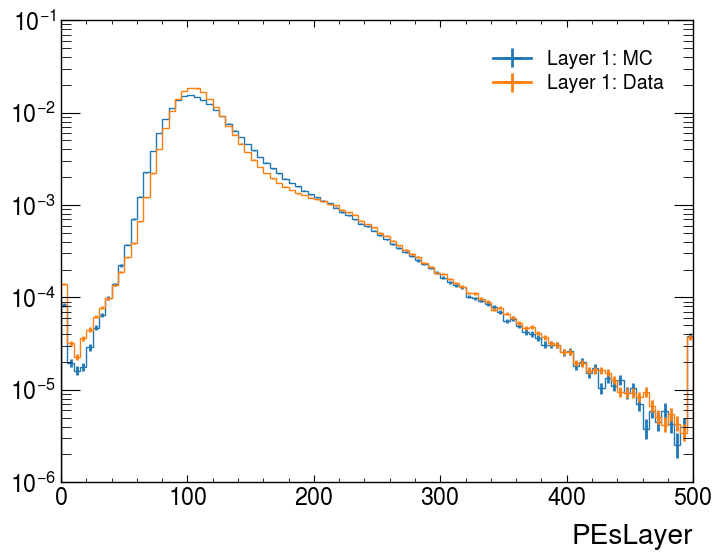

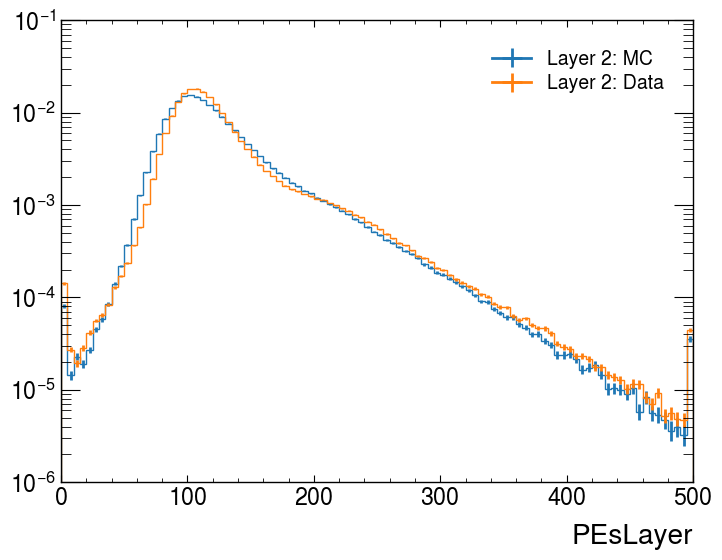

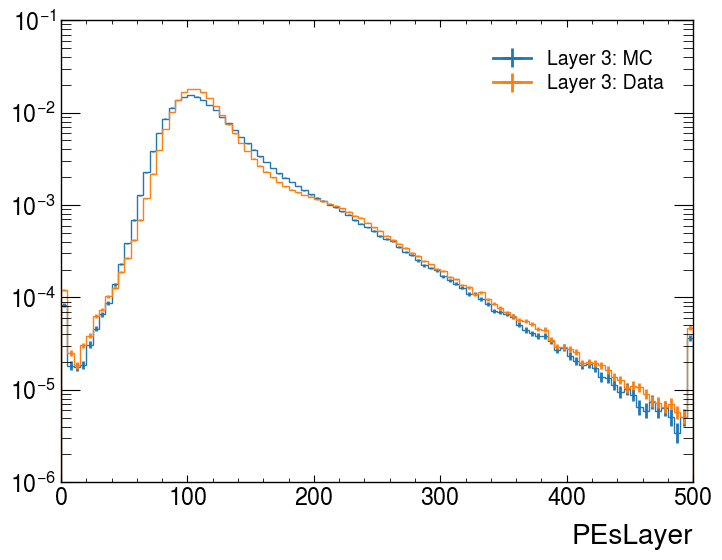

In [231]:
for layer in range(0,4):
    plt.figure()
    h_PEsLayerSort[:, 3, "all", True, layer].plot(flow="sum", label='Layer %d: MC'%layer)
    h_PEsLayerSort[:, 3, "all", False, layer].plot(flow="sum", label='Layer %d: Data'%layer)
    plt.yscale('log');
    plt.legend()
    plt.xlabel("PEsLayerSort")

for layer in range(0,4):
    plt.figure()
    h_PEsLayer[:, 3, "all", True, layer].plot(flow="sum", label='Layer %d: MC'%layer, density=True)
    h_PEsLayer[:, 3, "all", False, layer].plot(flow="sum", label='Layer %d: Data'%layer, density=True)
    plt.yscale('log');
    plt.xlabel("PEsLayer")
    plt.legend()    

In [207]:
def get_extrapolated_efficiency(cut, data_type, nfold):
    h = h_PEsLayer[:, 3, cut, data_type, :]
    # Normalize histogram to unity
    normalized_hist = np.mean(h, axis=1) / np.mean(h, axis=1).sum()
    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = binom.cdf(3-nfold, 4, 1 - cdf)
    return cdf

<Figure size 800x600 with 0 Axes>

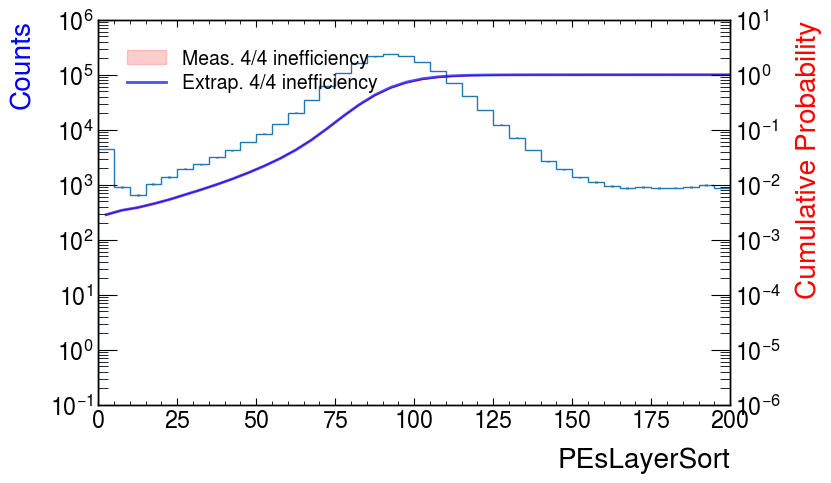

<Figure size 800x600 with 0 Axes>

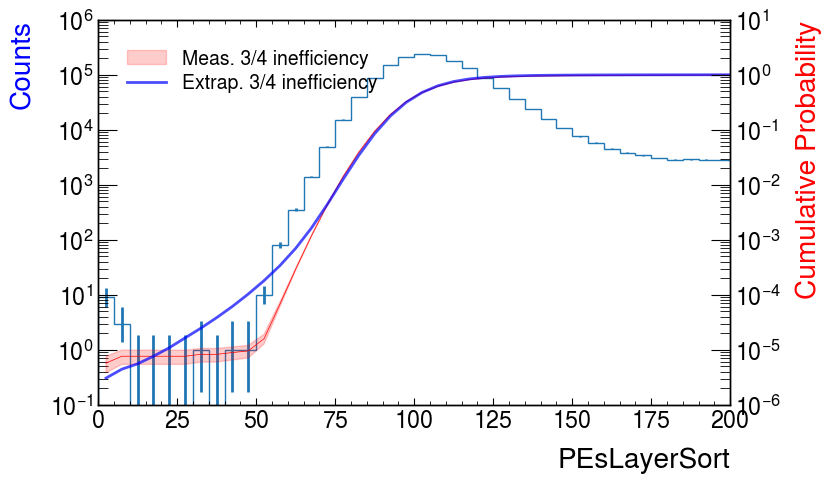

<Figure size 800x600 with 0 Axes>

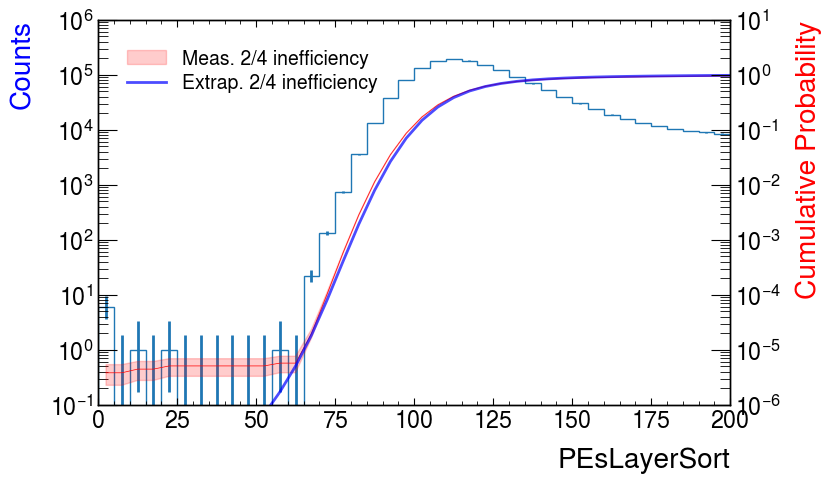

<Figure size 800x600 with 0 Axes>

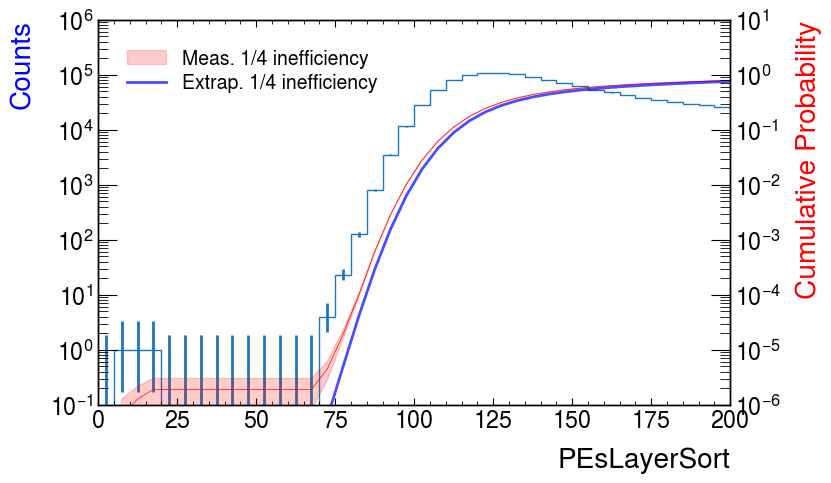

In [260]:
def plot_efficiency(nfold, ismc):
    # Create histogram using hist package
    h = h_PEsLayerSort[:, 3, "all", ismc, nfold]

    # Normalize histogram to unity
    normalized_hist = h.values() / h.sum(flow=True)

    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = np.clip(cdf, 1e-10, 1 - 1e-10)

    # Calculate the error bars for the CDF
    error_cdf = np.sqrt(cdf * (1 - cdf) / h.sum(flow=True))

    # Plot the normalized histogram and CDF with error bars on the same axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the second lowest PEs
    mplhep.histplot(h, ax=ax1, label='PEs layer: sorted', flow="sum")
    # Create a second y-axis
    ax2 = ax1.twinx()
    ax2.fill_between(h.axes[0].centers, cdf - error_cdf, cdf + error_cdf, color='red', alpha=0.2, label='Meas. %d/4 inefficiency'%(4-nfold))
    ax2.plot(h.axes[0].centers, cdf, 'r-', linewidth=0.5)

    cdf_est = get_extrapolated_efficiency("all", ismc, nfold)
    ax2.plot(h.axes[0].centers, cdf_est, 'b-', alpha=0.7, label='Extrap. %d/4 inefficiency'%(4-nfold))

    # Set labels for both y-axes
    ax1.set_ylabel('Counts', color='blue')
    ax2.set_ylabel('Cumulative Probability', color='red')

    plt.legend(loc='upper left')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    plt.xlim(0, 200);
    plt.ylim(1E-6, 10);

for nfold in range(0,4):
    plt.figure()
    plot_efficiency(nfold, False);

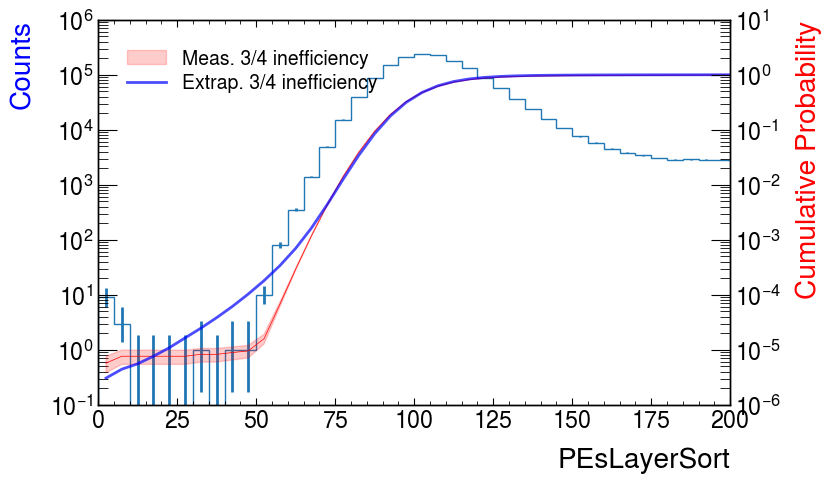

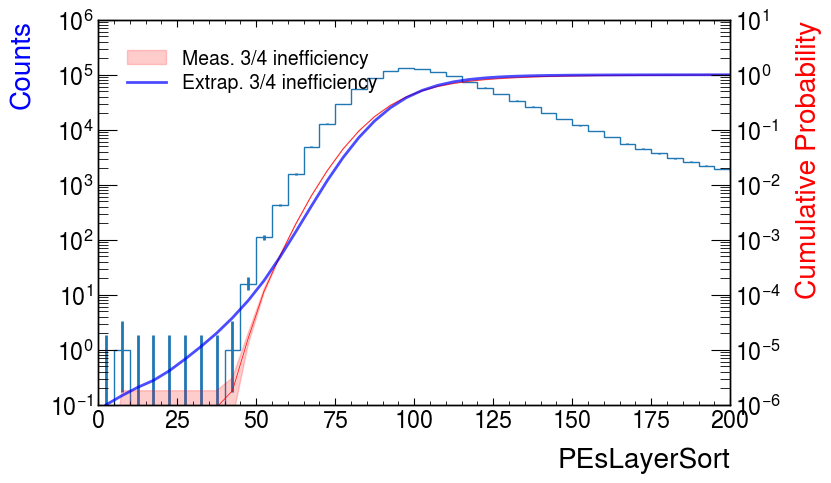

In [261]:
plot_efficiency(1, False);
plot_efficiency(1, True);

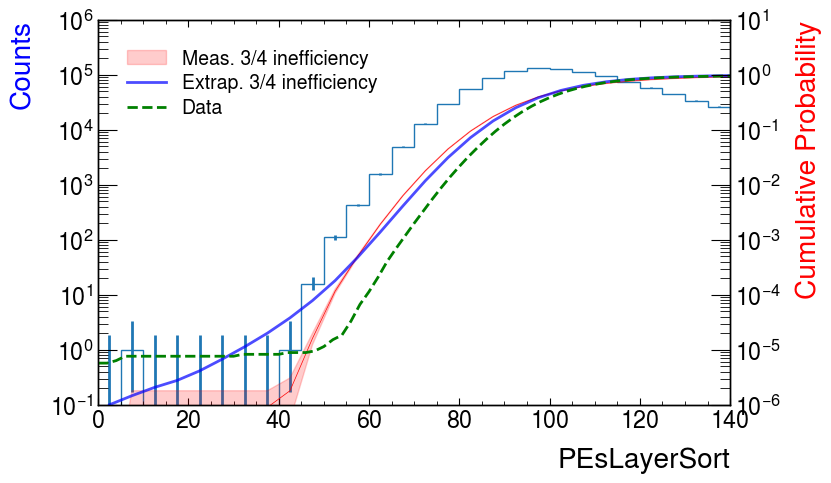

In [262]:
#Just a cross-check

# Plot MC
plot_efficiency(1, True);

#Plot Data
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[4] & (ar_skim["mc"] == False)]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=1000, range=(0, 2000))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative, "--g", label='Data')
plt.legend()
plt.yscale('log');
plt.xlim(0,140);

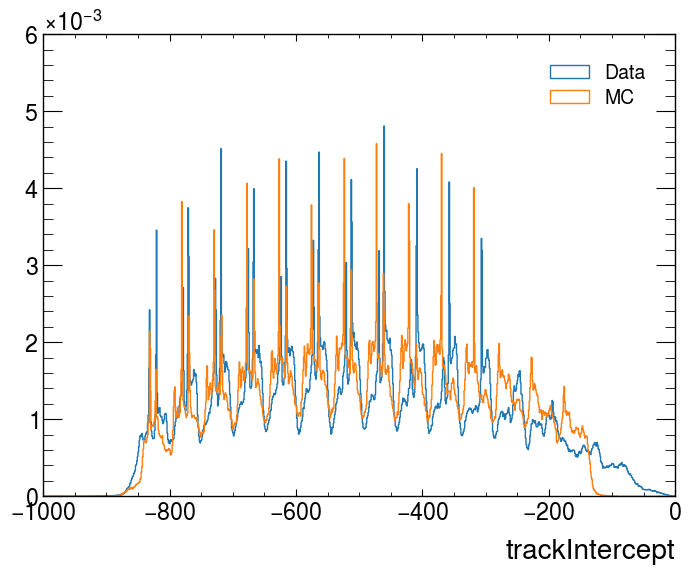

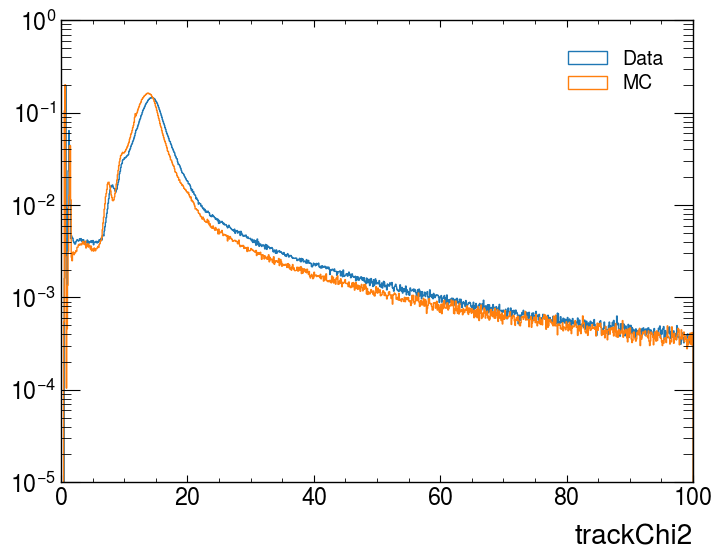

In [212]:
#plt.hist(ar_skim[ar_skim['mc']==True]['trackIntercept'], bins=1000, range=(20000, 21000), histtype='step');
plt.hist(ar_skim[ar_skim['mc']==False]['trackIntercept'], bins=1000, range=(-1000, 0), histtype='step', density=True, label="Data");
plt.hist(ar_skim[ar_skim['mc']==True]['trackIntercept']+20, bins=1000, range=(-1000, 0), histtype='step', density=True, label="MC");
plt.legend()
plt.xlabel("trackIntercept")

plt.figure()

plt.hist(ar_skim[(ar_skim['mc']==False)]['trackChi2NDF'], bins=1000, range=(0, 100), histtype='step', density=True, label="Data");
plt.hist(ar_skim[(ar_skim['mc']==True)]['trackChi2NDF'], bins=1000, range=(0, 100), histtype='step', density=True, label="MC");
plt.legend()
plt.yscale('log')
plt.xlabel("trackChi2");

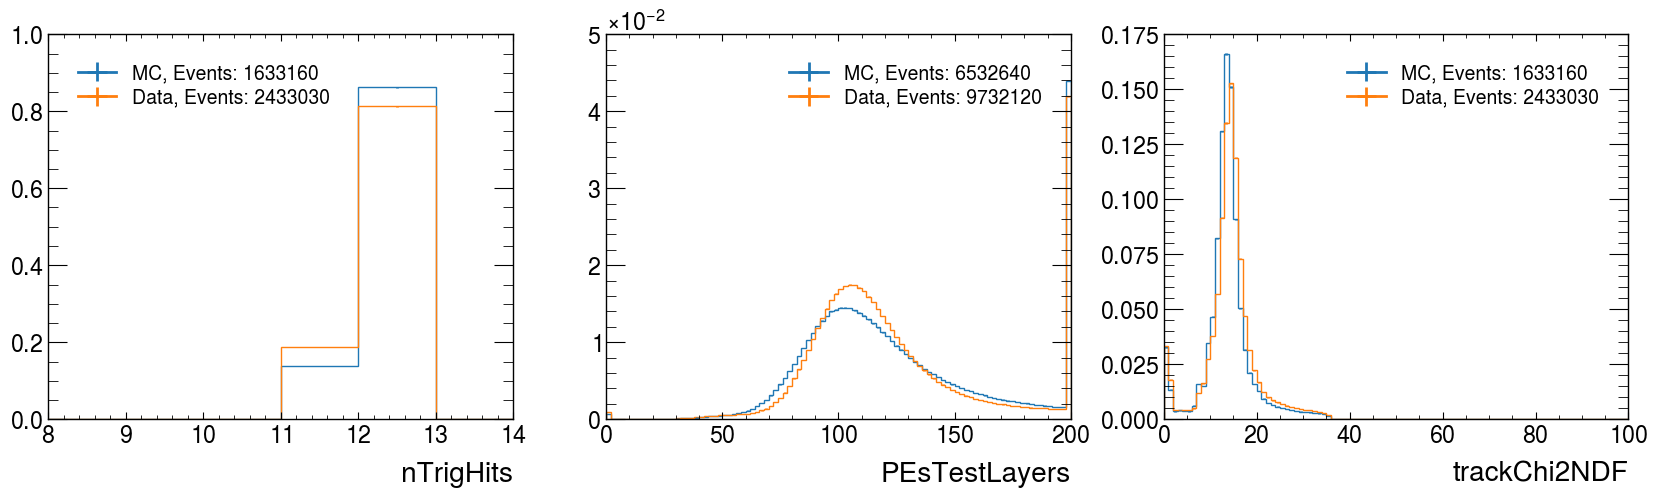

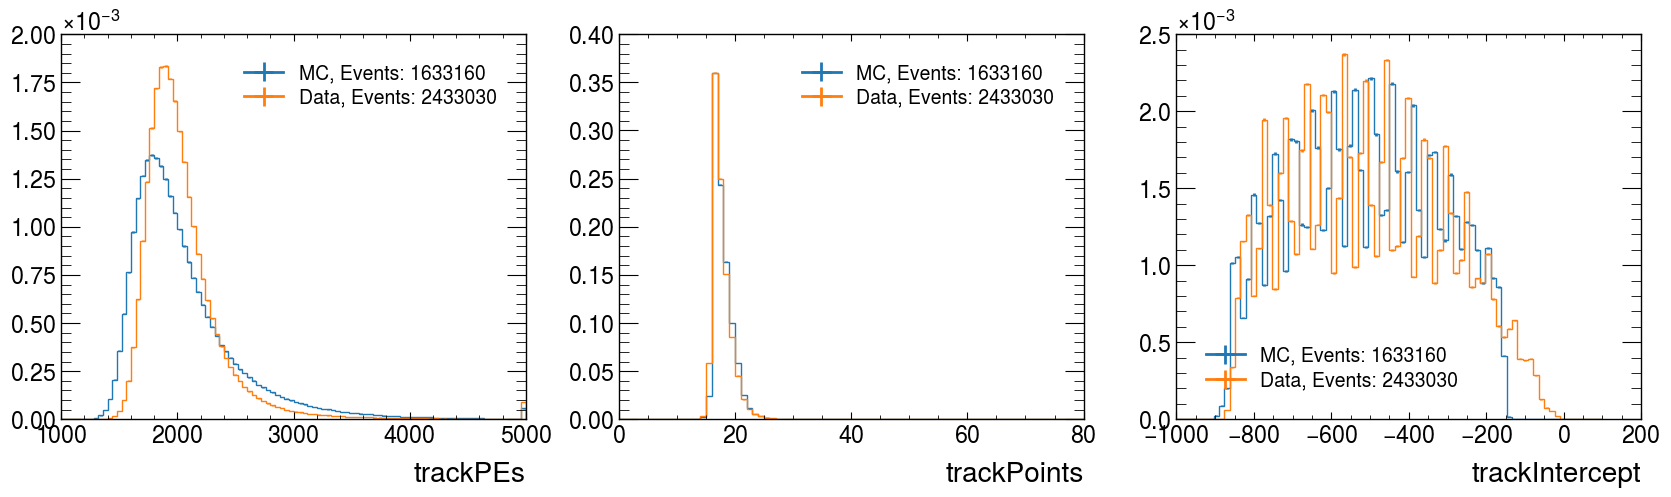

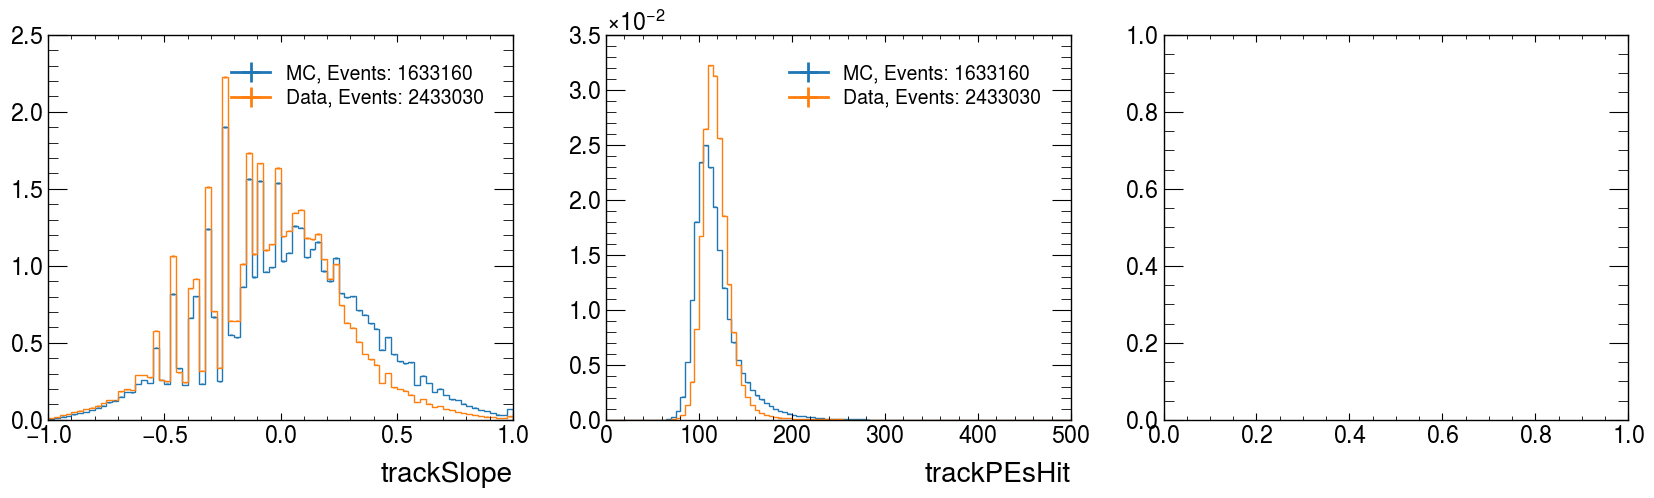

In [269]:
for idx, histogram in enumerate(histogram_list[:-2]):
    ncols = 3
    ax_id = idx%ncols
    if ax_id == 0:
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 5))

    h = histogram[:, 3, "trackChi2", True]
    mplhep.histplot(h, ax=axes[ax_id], label="MC, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")

    h = histogram[:, 3, "trackChi2", False]
    mplhep.histplot(h, ax=axes[ax_id], label="Data, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")
    
    axes[ax_id].set_xlabel(histogram.axes[0].label)
    axes[ax_id].legend()
#    axes[ax_id].set_yscale('log')

Distributions before any cuts 

In [265]:
#Apply cuts
ar_3l = ar_skim[cut_categories[4] & (ar_skim['nTestHits']<3) & (ar_skim['mc']==True)]  # less than 3 hits
ar_4e = ar_skim[cut_categories[4] & (ar_skim['nTestHits']==4) & (ar_skim['mc']==True)] # equal to 4 hits

In [266]:
pd.set_option('display.max_rows', None)
ak.to_dataframe(ar_3l)

spillNumber  eventNumber  runNumber  subrunNumber  \
entry subentry                                                      
0     0                   1         7478       1001           305   
      1                   1         7478       1001           305   
      2                   1         7478       1001           305   
      3                   1         7478       1001           305   

                   trackPEs  trackPoints   trackChi2  trackIntercept  \
entry subentry                                                         
0     0         1373.463867           15  288.377686     -371.208984   
      1         1373.463867           15  288.377686     -371.208984   
      2         1373.463867           15  288.377686     -371.208984   
      3         1373.463867           15  288.377686     -371.208984   

                trackSlope  nTrigHits  PEsTestLayers    mc  nTestHits  \
entry subentry                                                          
0     0           0.031802         12      96.328495  True          2   
      1           0.031802         12      13.646430  True          2   
      2           0.031802         12       9.225286  True          2   
      3           0.031802         12       0.000000  True          2   

                trackChi2NDF  
entry subentry                
0     0            22.182899  
      1            22.182899  
      2            22.182899  
      3            22.182899

In [264]:
eff = len(ar_3l)/len(ar_4e)
print("Efficiency at 10 PE: %.2e"%eff)

Efficiency at 10 PE: 9.01e-07
